In [1]:
from pyod.utils.data import generate_data
from pyod.models.ocsvm import OCSVM 
from pyod.models.deep_svdd import DeepSVDD 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Metrics for: OCSVM(cache_size=200, coef0=0.0, contamination=0.15, degree=3, gamma='auto',
   kernel='linear', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)
Balanced accuracy train =  1.0
Balanced accuracy test =  0.9833333333333334
ROC auc score train =  1.0
ROC auc score test =  1.0


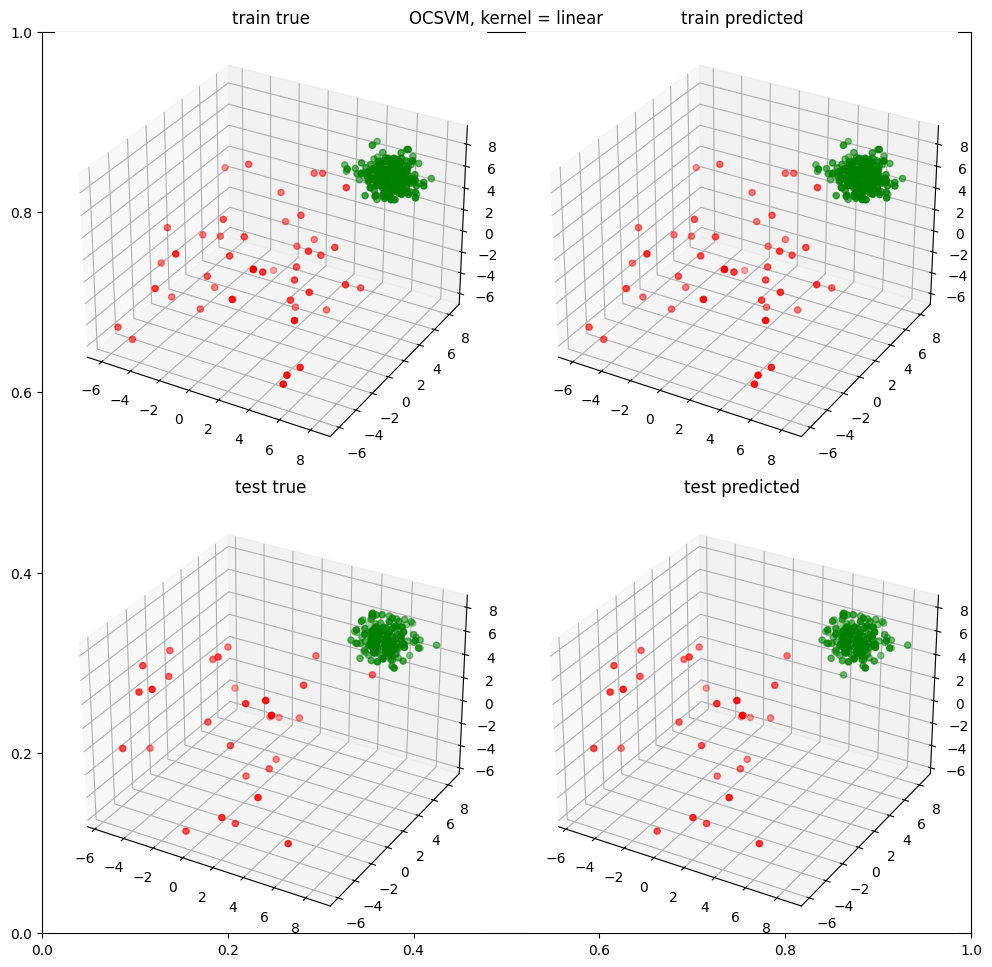

Metrics for: OCSVM(cache_size=200, coef0=0.0, contamination=0.15, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)
Balanced accuracy train =  0.9869281045751634
Balanced accuracy test =  0.9803921568627452
ROC auc score train =  0.9995642701525054
ROC auc score test =  0.9998039215686275


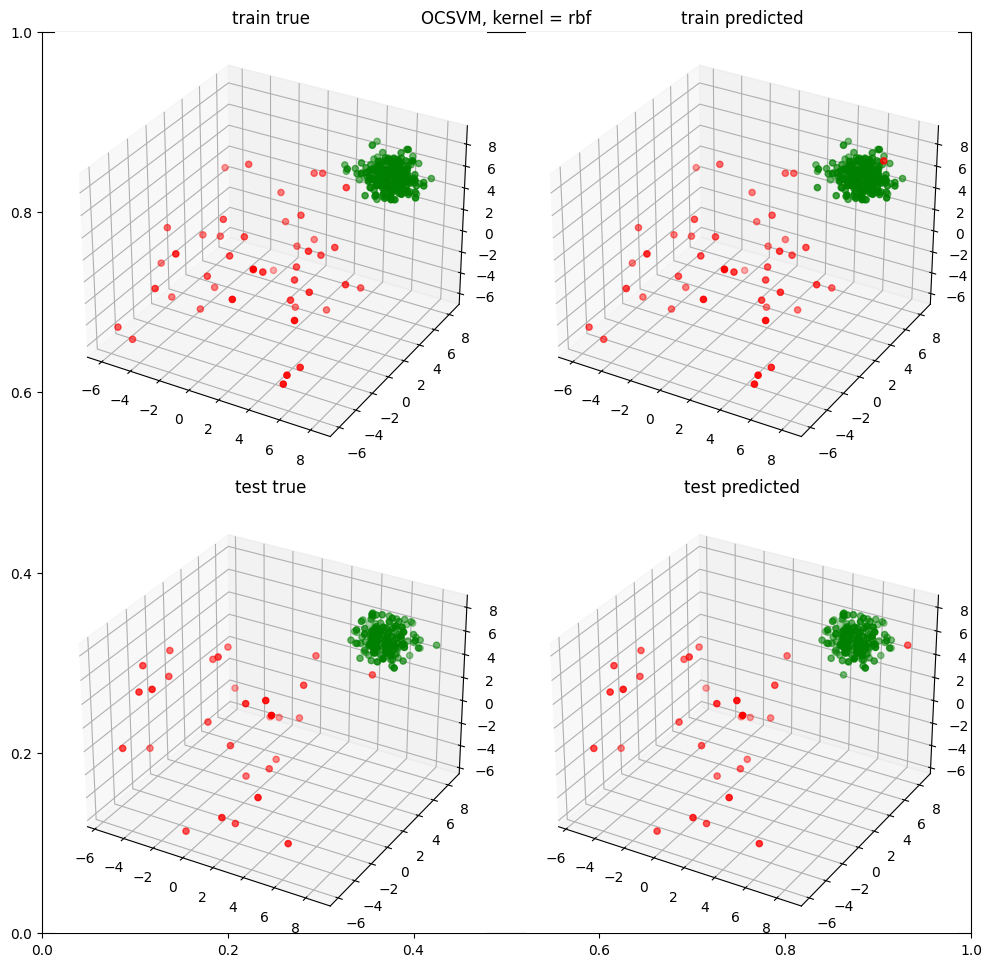

Epoch 1/100, Loss: 10.08881139755249
Epoch 2/100, Loss: 9.666748970746994
Epoch 3/100, Loss: 9.250985205173492
Epoch 4/100, Loss: 10.291800677776337
Epoch 5/100, Loss: 9.536351591348648
Epoch 6/100, Loss: 10.376396715641022
Epoch 7/100, Loss: 9.910955101251602
Epoch 8/100, Loss: 10.436792850494385
Epoch 9/100, Loss: 9.78917670249939
Epoch 10/100, Loss: 10.101368188858032
Epoch 11/100, Loss: 9.981725573539734
Epoch 12/100, Loss: 9.730349600315094
Epoch 13/100, Loss: 9.474388480186462
Epoch 14/100, Loss: 10.009029269218445
Epoch 15/100, Loss: 9.244614392518997
Epoch 16/100, Loss: 9.573018372058868
Epoch 17/100, Loss: 9.680001497268677
Epoch 18/100, Loss: 9.24307668209076
Epoch 19/100, Loss: 9.38470658659935
Epoch 20/100, Loss: 9.237645044922829
Epoch 21/100, Loss: 10.070671916007996
Epoch 22/100, Loss: 9.318737179040909
Epoch 23/100, Loss: 9.303028434515
Epoch 24/100, Loss: 9.589113593101501
Epoch 25/100, Loss: 9.521217197179794
Epoch 26/100, Loss: 9.614350736141205
Epoch 27/100, Loss: 9

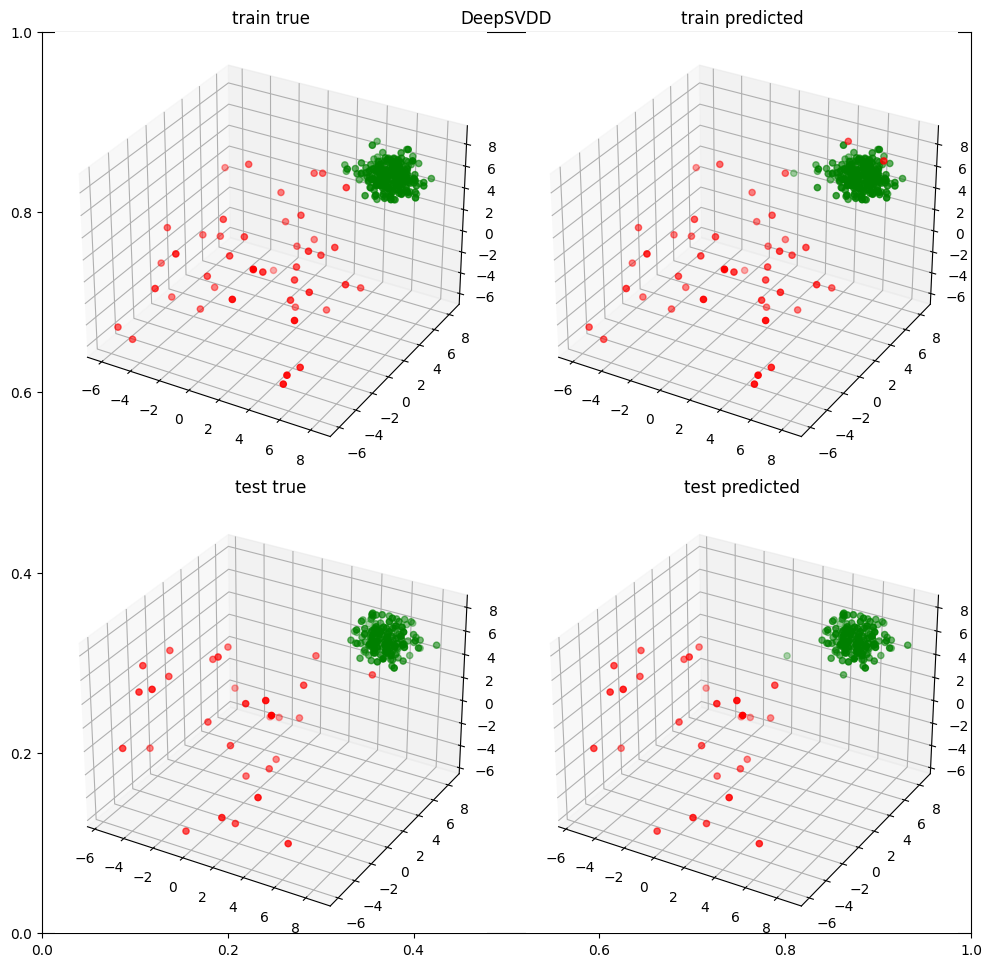

In [3]:
def plot_outliers(fig, position, X, y, title):
    ax = fig.add_subplot(*position, projection='3d')
    ax.set_title(title)
    ax.scatter(X[:, 0][y], X[:, 1][y], X[:, 2][y], c="r")
    ax.scatter(X[:, 0][~y], X[:, 1][~y], X[:, 2][~y], c="g")

# Exercise 1
contamination = 0.15

X_train, X_test, y_train, y_test = generate_data(n_train=300, n_test=200, n_features=3, contamination=contamination, random_state=42)
y_train = y_train.astype(bool)
y_test =  y_test.astype(bool)

def benchmark_model(title, model):
    fig = plt.figure(figsize=(10, 10))
    model.fit(X_train)

    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    predictions_scores_train = model.decision_function(X_train)
    predictions_scores_test = model.decision_function(X_test)
    
    print(f"Metrics for: {model}")
    print(f"Balanced accuracy train =  {balanced_accuracy_score(y_train, predictions_train)}")
    print(f"Balanced accuracy test =  {balanced_accuracy_score(y_test, predictions_test)}")

    print(f"ROC auc score train =  {roc_auc_score(y_train, predictions_scores_train)}")
    print(f"ROC auc score test =  {roc_auc_score(y_test, predictions_scores_test)}")

    plt.title(title)
    plot_outliers(fig, (2, 2, 1), X_train, y_train, "train true")
    plot_outliers(fig, (2, 2, 2), X_train, predictions_train.astype(bool), "train predicted")
    plot_outliers(fig, (2, 2, 3), X_test, y_test, "test true")
    plot_outliers(fig, (2, 2, 4), X_test, predictions_test.astype(bool), "test predicted")
    fig.tight_layout()
    plt.show()

benchmark_model("OCSVM, kernel = linear", OCSVM(contamination=contamination, kernel="linear"))
benchmark_model("OCSVM, kernel = rbf", OCSVM(contamination=contamination, kernel="rbf"))
benchmark_model("DeepSVDD", DeepSVDD(n_features=3, contamination=contamination))

In [4]:
# Exercise 2

mat = loadmat("cardio.mat")
X, y = mat["X"], mat["y"].squeeze()

# Generating the train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")

# Here we convert from the pyod labels (0 from inliers, 1 for outliers) 
# to the labels returned by the sklearn.OneClassSVM model (-1 for outliers and 1 for inliers)
y_train = 1 - 2*y_train
y_test= 1 - 2*y_test

parameters_set = { 
    "nu": np.linspace(0.05, 0.8, 20),
    "gamma": ["auto", "scale", 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
} 

svm = OneClassSVM()
grid_search = GridSearchCV(svm, parameters_set, scoring="balanced_accuracy", cv = 5)

pipe = Pipeline([('scaler', StandardScaler()), ('grid_search', grid_search)])
pipe.fit(X_train, y_train)

best_params = pipe["grid_search"].best_params_
best_score = pipe["grid_search"].best_score_
print(f"Best params: {best_params}")
print(f"Best estimator performance on the training set (cross-val): {best_score}")

predictions = pipe.predict(X_test)
print(f"Balanced accuracy score on the test set: {balanced_accuracy_score(y_test, predictions)}")

The shape of X_train is (732, 21)
The shape of X_test is (1099, 21)
Best params: {'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.24736842105263157}
Best estimator performance on the training set (cross-val): 0.9125403946123424
Balanced accuracy score on the test set: 0.8764048445988066


In [ ]:
# Exercise 3
mat = loadmat("shuttle.mat")
X, y = mat["X"], mat["y"].squeeze()

# Generating the train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Calculating the contamination rate on the training set.
contamination_rate = y_train.mean()

# Standard scaling.
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Here we fit the model, compute the predictions and the scores, then
# print the metrics.
def benchmark_model(model):
    model.fit(X_train)

    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    scores_train = model.decision_function(X_train)
    scores_test = model.decision_function(X_test)
    
    print(f"Metrics for: {model}")
    print(f"Balanced accuracy train =  {balanced_accuracy_score(y_train, predictions_train)}")
    print(f"Balanced accuracy test =  {balanced_accuracy_score(y_test, predictions_test)}")
    print(f"ROC auc score train =  {roc_auc_score(y_train, scores_train)}")
    print(f"ROC auc score test =  {roc_auc_score(y_test, scores_test)}")


benchmark_model(OCSVM(contamination=contamination_rate, kernel="rbf"))
benchmark_model(OCSVM(contamination=contamination_rate, kernel="linear"))
benchmark_model(DeepSVDD(n_features=9, 
                         contamination=contamination_rate, 
                         preprocessing=False))
benchmark_model(DeepSVDD(n_features=9, 
                         contamination=contamination_rate, 
                         preprocessing=False, 
                         hidden_neurons=[128,64,32]))

benchmark_model(DeepSVDD(n_features=9, 
                         contamination=contamination_rate, 
                         preprocessing=False, 
                         hidden_neurons=[128,64,32], 
                         output_activation="softmax"))

benchmark_model(DeepSVDD(n_features=9, 
                         contamination=contamination_rate, 
                         preprocessing=False, 
                         hidden_neurons=[256,128,64, 32], 
                         output_activation="softmax"))


Epoch 1/100, Loss: 134.37738698720932
Epoch 2/100, Loss: 125.77970347180963
Epoch 3/100, Loss: 127.9886824041605
Epoch 4/100, Loss: 128.71573543921113
Epoch 5/100, Loss: 126.26952922716737
Epoch 6/100, Loss: 114.6167854219675
Epoch 7/100, Loss: 130.74332686513662
Epoch 8/100, Loss: 122.08007859438658
Epoch 9/100, Loss: 132.13343175128102
Epoch 10/100, Loss: 118.08908228576183
Epoch 11/100, Loss: 137.42225145548582
Epoch 12/100, Loss: 119.11106488481164
Epoch 13/100, Loss: 119.64549175649881
Epoch 14/100, Loss: 124.2947885133326
Epoch 15/100, Loss: 113.31544705107808
Epoch 16/100, Loss: 128.55257180705667
Epoch 17/100, Loss: 129.47144282981753
Epoch 18/100, Loss: 130.07906999439
Epoch 19/100, Loss: 133.5348354075104
Epoch 20/100, Loss: 126.5740671902895
Epoch 21/100, Loss: 116.74745629355311
Epoch 22/100, Loss: 129.1066128835082
Epoch 23/100, Loss: 120.28608298115432
Epoch 24/100, Loss: 132.4354897737503
Epoch 25/100, Loss: 123.61644828692079
Epoch 26/100, Loss: 125.19418799877167
Epoch

KeyboardInterrupt: 